# Project : Using transformer with huggingface

## Rubric

### 1. 모델과 데이터를 정상적으로 불러오고, 작동하는 것을 확인하였다.	
klue/bert-base를 NSMC 데이터셋으로 fine-tuning 하여, 모델이 정상적으로 작동하는 것을 확인하였다.

### 2. Preprocessing을 개선하고, fine-tuning을 통해 모델의 성능을 개선시켰다.	
Validation accuracy를 90% 이상으로 개선하였다.

### 3. 모델 학습에 Bucketing을 성공적으로 적용하고, 그 결과를 비교분석하였다.	
Bucketing task을 수행하여 fine-tuning 시 연산 속도와 모델 성능 간의 trade-off 관계가 발생하는지 여부를 확인하고, 분석한 결과를 제시하였다.

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
dataset = load_dataset("nsmc")
print(dataset['train'][:5])
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")


Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

{'id': ['9976970', '3819312', '10265843', '9045019', '6483659'], 'document': ['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다'], 'label': [0, 1, 0, 0, 1]}
Train dataset size: 150000
Test dataset size: 50000


In [3]:
# 클래스 분포 확인
print("Class names in Train dataset:", dataset['train'].features['label'].names)
print("Number of classes in Train dataset:", dataset['train'].features['label'].num_classes)


Class names in Train dataset: ['negative', 'positive']
Number of classes in Train dataset: 2


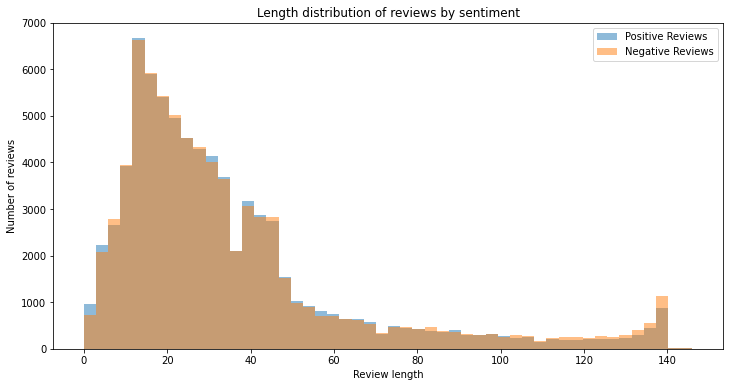

In [4]:
import matplotlib.pyplot as plt

# positive와 negative 라벨에 대한 리뷰 길이 계산
positive_lengths = [len(doc) for doc, label in zip(dataset['train']['document'], dataset['train']['label']) if label == 1]
negative_lengths = [len(doc) for doc, label in zip(dataset['train']['document'], dataset['train']['label']) if label == 0]

# 히스토그램으로 길이 분포 시각화
plt.figure(figsize=(12, 6))

plt.hist(positive_lengths, bins=50, alpha=0.5, label='Positive Reviews')
plt.hist(negative_lengths, bins=50, alpha=0.5, label='Negative Reviews')

plt.title('Length distribution of reviews by sentiment')
plt.xlabel('Review length')
plt.ylabel('Number of reviews')
plt.legend()

plt.show()


In [5]:
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [6]:
def encode_examples(examples):
    outputs = tokenizer(examples['document'], truncation=True, padding='max_length', max_length=60)
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
        "labels": examples['label']
    }

encoded_dataset = dataset['train'].map(encode_examples, batched=True)
encoded_test_dataset = dataset['test'].map(encode_examples, batched=True)

train_indices, val_indices = train_test_split(list(range(len(encoded_dataset))), test_size=0.1, stratify=dataset['train']['label'])

train_dataset = encoded_dataset.select(train_indices)
val_dataset = encoded_dataset.select(val_indices)

def dataset_to_tensors(dataset):
    input_ids = torch.tensor(dataset["input_ids"], dtype=torch.long)
    attention_mask = torch.tensor(dataset["attention_mask"], dtype=torch.long)
    labels = torch.tensor(dataset["labels"], dtype=torch.long)
    return TensorDataset(input_ids, attention_mask, labels)

train_tensor_dataset = dataset_to_tensors(train_dataset)
val_tensor_dataset = dataset_to_tensors(val_dataset)
test_tensor_dataset = dataset_to_tensors(encoded_test_dataset)

# 배치사이즈는 nvidia-smi를 통해서 가용 자원을 확인해가며 조정했다
train_dataloader = DataLoader(train_tensor_dataset, batch_size=270, shuffle=True)
val_dataloader = DataLoader(val_tensor_dataset, batch_size=270)
test_dataloader = DataLoader(test_tensor_dataset, batch_size=270)


Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-1078b2bbcf6ecd9d.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-fd1df9cee0699915.arrow


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
loss_fn = torch.nn.CrossEntropyLoss()


In [8]:
from tqdm import tqdm

for epoch in range(3):
    print(f"\nStarting Epoch {epoch + 1}...")
    
    model.train()
    total_train_loss = 0
    print("Training...")
    

    for batch in tqdm(train_dataloader, desc="Training", total=len(train_dataloader)):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"\nEnd of Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}")
    
    model.eval()
    total_val_loss = 0
    print("Validating...")
    

    for batch in tqdm(val_dataloader, desc="Validation", total=len(val_dataloader)):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"\nEnd of Epoch {epoch + 1}, Average Validation Loss: {avg_val_loss:.4f}\n")
    
    # Test accuracy after each epoch
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(test_dataloader, desc="Testing", total=len(test_dataloader)):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
        
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    print(f"\nEnd of Epoch {epoch + 1}, Test Accuracy: {accuracy*100:.2f}%")
    
    # If the test accuracy exceeds 90%, stop training
    if accuracy * 100 > 90:
        print("\nReached 90% accuracy. Stopping training!")
        break



Starting Epoch 1...
Training...


Training: 100%|██████████| 500/500 [19:41<00:00,  2.36s/it]



End of Epoch 1, Average Training Loss: 0.2874
Validating...


Validation: 100%|██████████| 56/56 [00:49<00:00,  1.13it/s]



End of Epoch 1, Average Validation Loss: 0.2417



Testing: 100%|██████████| 186/186 [02:44<00:00,  1.13it/s]



End of Epoch 1, Test Accuracy: 89.94%

Starting Epoch 2...
Training...


Training: 100%|██████████| 500/500 [19:41<00:00,  2.36s/it]



End of Epoch 2, Average Training Loss: 0.2034
Validating...


Validation: 100%|██████████| 56/56 [00:49<00:00,  1.13it/s]



End of Epoch 2, Average Validation Loss: 0.2347



Testing: 100%|██████████| 186/186 [02:44<00:00,  1.13it/s]


End of Epoch 2, Test Accuracy: 90.25%

Reached 90% accuracy. Stopping training!


In [ ]:
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    67W /  70W |  14858MiB / 15109MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
+-----------------------------------------------------------------------------+

In [8]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [9]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',             # 출력 결과들이 저장될 디렉토리
    num_train_epochs=2,                 # 학습할 총 에포크 수
    per_device_train_batch_size=270,    # 학습에 사용할 배치 크기
    per_device_eval_batch_size=270,     # 평가에 사용할 배치 크기
    evaluation_strategy="epoch",        # 에포크마다 평가
    save_strategy="epoch",              # 에포크마다 모델 저장
    save_total_limit=2,                 # 전체 저장된 모델의 최대 개수
    group_by_length=True                # 같은 길이의 입력 시퀀스끼리 그룹화
)

In [10]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, tensor_dataset):
        self.tensor_dataset = tensor_dataset

    def __len__(self):
        return len(self.tensor_dataset)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tensor_dataset[idx][0],
            'attention_mask': self.tensor_dataset[idx][1],
            'labels': self.tensor_dataset[idx][2]
        }

# TensorDataset을 CustomDataset으로 변환합니다.
train_custom_dataset = CustomDataset(train_tensor_dataset)
val_custom_dataset = CustomDataset(val_tensor_dataset)


In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_custom_dataset,
    eval_dataset=val_custom_dataset,
    data_collator=data_collator
)


In [14]:
trainer.train()

eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

***** Running training *****
  Num examples = 135000
  Num Epochs = 2
  Instantaneous batch size per device = 270
  Total train batch size (w. parallel, distributed & accumulation) = 270
  Gradient Accumulation steps = 1
  Total optimization steps = 1000


Epoch,Training Loss,Validation Loss
1,0.281700,0.232005
2,0.183300,0.230171


***** Running Evaluation *****
  Num examples = 15000
  Batch size = 270
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 270
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 15000
  Batch size = 270


Evaluation results: {'eval_loss': 0.23017093539237976, 'eval_runtime': 49.6397, 'eval_samples_per_second': 302.177, 'eval_steps_per_second': 1.128, 'epoch': 2.0}


In [17]:
from tqdm import tqdm

def compute_test_accuracy(model, test_dataloader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(test_dataloader, desc="Testing", total=len(test_dataloader)):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
        
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

test_accuracy = compute_test_accuracy(model, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Testing: 100%|██████████| 186/186 [02:44<00:00,  1.13it/s]

Test Accuracy: 90.43%


In [ ]:
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    88W /  70W |  14858MiB / 15109MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
+-----------------------------------------------------------------------------+

두 방법 모두 동일한 성능을 냈다. 어떤 방법을 사용해도 상관 없을것 같다.

max_length를 60으로 작게 잡았기 때문에, group_by_length=True가 큰 의미를 갖지 못한것 같다.